In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
namesngenre = np.load('./dataset/namesngenre.npy')

In [11]:
namesngenre

array([['Toy Story (1995)',
        'Adventure|Animation|Children|Comedy|Fantasy'],
       ['Jumanji (1995)', 'Adventure|Children|Fantasy'],
       ['Grumpier Old Men (1995)', 'Comedy|Romance'],
       ...,
       ['Elsa & Fred (2005)', 'Comedy|Drama|Romance'],
       ['Tomb Raider (2018)', 'Action|Adventure|Fantasy'],
       ['Fred Armisen: Standup for Drummers (2018)', 'Comedy']],
      dtype='<U158')

In [12]:
ratings_train = np.load('./dataset/ratings_train.npy')

In [13]:
ratings_train.shape

(610, 4980)

In [14]:
ratings_train

array([[ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  2., nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [15]:
np.nanmax(ratings_train)

5.0

# Matrix Factorization

In [34]:
import MF

In [27]:
k = 1

factorization = MF.MF(ratings_train, l=0.01, mu=0.01, k=k)


In [28]:
non_nan_indices = np.where(~np.isnan(ratings_train))
# Separate the row and column indices
row_indices, col_indices = non_nan_indices
R_non_nan = factorization.R[row_indices, col_indices]

In [30]:
factorization.fit(lr_I=0.0001, lr_U=0.0001, num_iterations=100)
prediction_full = factorization.predict()
prediction = prediction_full[row_indices, col_indices]
print(prediction)
factorization.RMSE_(prediction_full)

Iteration 1: Cost = 22388.793390470175. RMSE = 0.838026468135326
Iteration 2: Cost = 22367.741691297226. RMSE = 0.8376289149727438
Iteration 3: Cost = 22346.911891917505. RMSE = 0.8372353672704069
Iteration 4: Cost = 22326.299719696177. RMSE = 0.8368457498704029
Iteration 5: Cost = 22305.901026444753. RMSE = 0.8364599897736218
Iteration 6: Cost = 22285.7117835671. RMSE = 0.8360780160563539
Iteration 7: Cost = 22265.7280774473. RMSE = 0.8356997597908901
Iteration 8: Cost = 22245.94610505204. RMSE = 0.8353251539698958
Iteration 9: Cost = 22226.362169745506. RMSE = 0.8349541334343474
Iteration 10: Cost = 22206.972677298945. RMSE = 0.8345866348048324
Iteration 11: Cost = 22187.774132087532. RMSE = 0.8342225964160238
Iteration 12: Cost = 22168.76313346004. RMSE = 0.8338619582541597
Iteration 13: Cost = 22149.936372278135. RMSE = 0.8335046618973603
Iteration 14: Cost = 22131.29062761099. RMSE = 0.8331506504586327
Iteration 15: Cost = 22112.822763576296. RMSE = 0.8327998685314179
Iteration 16

0.8110262503041126

# Deep Matrix Factorization


In [82]:
import deepMF
import torch
import torch
import torch.nn as nn
import torch.optim as optim
%reload_ext autoreload
%autoreload 2

In [68]:
# Load the input data from a numpy file
ratings_train = np.load('dataset/ratings_train.npy')
ratings_test = np.load('dataset/ratings_test.npy')
# Replace NaN values with 0
ratings_train[np.isnan(ratings_train)] = 0
ratings_test[np.isnan(ratings_test)] = 0

In [69]:
total_data = ratings_train + ratings_test

non_empty_indices = np.where(total_data != 0)
non_empty_indices = np.array([non_empty_indices[0], non_empty_indices[1]])

indices = np.random.choice(np.array(range(non_empty_indices.shape[1])), size=non_empty_indices.shape[1], replace = False)

train_set_indices = indices[0:int(non_empty_indices.shape[1]*0.7)]
train_set_indices2d = np.array(non_empty_indices[:, train_set_indices])
train_set = np.zeros(total_data.shape)
train_set[train_set_indices2d[0], train_set_indices2d[1]] = total_data[train_set_indices2d[0], train_set_indices2d[1]]

test_set_indices = indices[int(non_empty_indices.shape[1]*0.7):]
test_set_indices2d = np.array(non_empty_indices[:, test_set_indices])
test_set = np.zeros(total_data.shape)
test_set[test_set_indices2d[0], test_set_indices2d[1]] = total_data[test_set_indices2d[0], test_set_indices2d[1]]

normalized_train_data = train_set/np.max(train_set)

normalized_test_data = test_set/np.max(test_set)

In [92]:
# Hyperparameters evaluation
encoded_dim = 32
input_size = normalized_train_data.shape 
hidden_size_row = 16
hidden_size_col = 64

In [43]:
optimizers = []
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizers.append((model, optim.Adam(model.parameters(), lr=0.001)))
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizers.append((model, optim.RAdam(model.parameters(), lr=0.001)))
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizers.append((model, optim.AdamW(model.parameters(), lr=0.001)))
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizers.append((model, optim.Rprop(model.parameters(), lr=0.001)))
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizers.append((model, optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)))

for i in range(len(optimizers)):
    deepMF.train_model(optimizers[i][0], optimizers[i][1], torch.FloatTensor(normalized_train_data), weight_decay=i>=5)
    # Pass the new input data through the trained model to get predictions
    predicted_similarity_scores = optimizers[i][0](torch.FloatTensor(normalized_train_data), torch.FloatTensor(normalized_train_data).T)
    target = torch.FloatTensor(train_set)
    print(torch.mean(torch.sqrt((predicted_similarity_scores[target!=0]*5 - target[target!=0])**2)))
    target = torch.FloatTensor(test_set)
    print(torch.mean(torch.sqrt((predicted_similarity_scores[target!=0]*5 - target[target!=0])**2)))

tensor(0.5228, grad_fn=<MeanBackward0>)
tensor(0.7152, grad_fn=<MeanBackward0>)
tensor(0.7113, grad_fn=<MeanBackward0>)
tensor(0.6021, grad_fn=<MeanBackward0>)
tensor(0.6689, grad_fn=<MeanBackward0>)
tensor(0.6710, grad_fn=<MeanBackward0>)
tensor(0.5735, grad_fn=<MeanBackward0>)
tensor(0.7000, grad_fn=<MeanBackward0>)
tensor(0.6967, grad_fn=<MeanBackward0>)
tensor(0.5080, grad_fn=<MeanBackward0>)
tensor(0.7614, grad_fn=<MeanBackward0>)
tensor(0.7689, grad_fn=<MeanBackward0>)
tensor(0.5538, grad_fn=<MeanBackward0>)
tensor(0.6994, grad_fn=<MeanBackward0>)
tensor(0.6960, grad_fn=<MeanBackward0>)


In [55]:
for k in [25, 30, 35, 40]:
    model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col, encoded_dim=k)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    deepMF.train_model(model, optimizer, torch.FloatTensor(normalized_train_data))
    # Pass the new input data through the trained model to get predictions
    predicted_similarity_scores = model(torch.FloatTensor(normalized_train_data), torch.FloatTensor(normalized_train_data).T)
    target = torch.FloatTensor(train_set)
    print(torch.mean(torch.sqrt((predicted_similarity_scores[target!=0]*5 - target[target!=0])**2)))
    target = torch.FloatTensor(test_set)
    print(torch.mean(torch.sqrt((predicted_similarity_scores[target!=0]*5 - target[target!=0])**2)))

tensor(0.5827, grad_fn=<MeanBackward0>)
tensor(0.6748, grad_fn=<MeanBackward0>)
tensor(0.5093, grad_fn=<MeanBackward0>)
tensor(0.7209, grad_fn=<MeanBackward0>)
tensor(0.5753, grad_fn=<MeanBackward0>)
tensor(0.6950, grad_fn=<MeanBackward0>)
tensor(0.5316, grad_fn=<MeanBackward0>)
tensor(0.6955, grad_fn=<MeanBackward0>)


In [94]:
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
deepMF.train_model(model, optimizer, torch.FloatTensor(normalized_train_data), test_data=test_set)

[1.8090029954910278, 1.518591046333313, 1.2772815227508545, 1.091922402381897, 0.9572230577468872, 0.8762134313583374, 0.8367995619773865, 0.8229821920394897, 0.8218688368797302, 0.8224519491195679, 0.8196720480918884, 0.8119210600852966, 0.8003397583961487, 0.7900006771087646, 0.7824667692184448, 0.7808458209037781, 0.7824122309684753, 0.7842073440551758, 0.7834173440933228, 0.7816700339317322, 0.7796587944030762, 0.7785606980323792, 0.7791494727134705, 0.7806158065795898, 0.7812602519989014, 0.7800217270851135, 0.7767158150672913, 0.7721425294876099, 0.7673644423484802, 0.7630724906921387, 0.75959712266922, 0.7566437721252441, 0.7537275552749634, 0.7507810592651367, 0.7479670643806458, 0.7455202341079712, 0.7436509728431702, 0.7425235509872437, 0.742059051990509, 0.7420749068260193, 0.7418891787528992, 0.7408671379089355, 0.7387839555740356, 0.7358809113502502, 0.7327429056167603, 0.7297643423080444, 0.7272637486457825, 0.725273847579956, 0.7237353920936584, 0.7225996851921082, 0.721

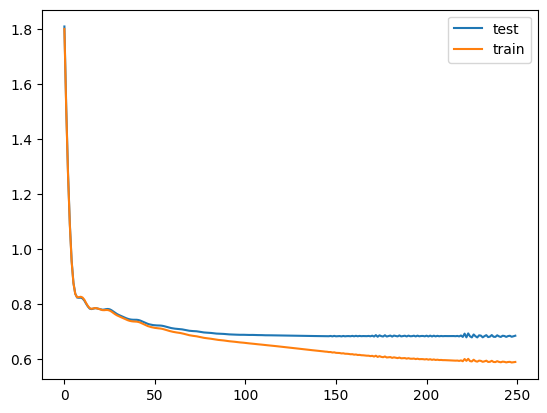

In [96]:
print(model.rmse_test_hist)
print(model.rmse_train_hist)
plt.plot(model.rmse_test_hist, label="test")
plt.plot(model.rmse_train_hist, label="train")
plt.legend()

## Result analysis

In [111]:
"""
    Use thise cell after running generate.py and assign the used file to calculate the train rmse.

    To have the test RMSE use the test file.
"""

non_normalized_train_data = np.load('./dataset/ratings_test.npy')
non_normalized_train_data[np.isnan(non_normalized_train_data)] = 0

output = np.load('output.npy')
predictions = output[non_normalized_train_data!=0]
targets = non_normalized_train_data[non_normalized_train_data!=0]
# Calculate the squared differences between predictions and targets
squared_errors = (predictions - targets) ** 2

# Calculate the mean of squared errors
mean_squared_error = squared_errors.mean()

# Calculate the square root to get RMSE
rmse_value = np.sqrt(mean_squared_error)
print(rmse_value)


0.9059558822095913


0.8275776851270916
